In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder, DatasetFolder
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from tqdm import tqdm
import shutil

cudnn.benchmark = True
plt.ion()

In [2]:
mp.set_start_method('spawn')

In [30]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  #.Resize((400, 400)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),   #.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [31]:
resnet_train_data_path = r"/nfs/home/tgv3756/dlproject/data/resnet_train_data"
resnet_val_data_path = r"/nfs/home/tgv3756/dlproject/data/resnet_val_data"

train_dataset = ImageFolder(root=resnet_train_data_path, transform=train_transform)
val_dataset = ImageFolder(root=resnet_val_data_path, transform=val_test_transform)

In [32]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, generator=torch.Generator(device='cuda'))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, generator=torch.Generator(device='cuda'))

In [72]:
class_labels = train_dataset.classes
class_labels

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [92]:
label_mappings = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

In [34]:
torch.cuda.is_available()

True

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')          
else:
    device = torch.device('cpu')
    
torch.set_default_device(device)
print(f"Using {device} device")

Using cuda device


Displaying some training images

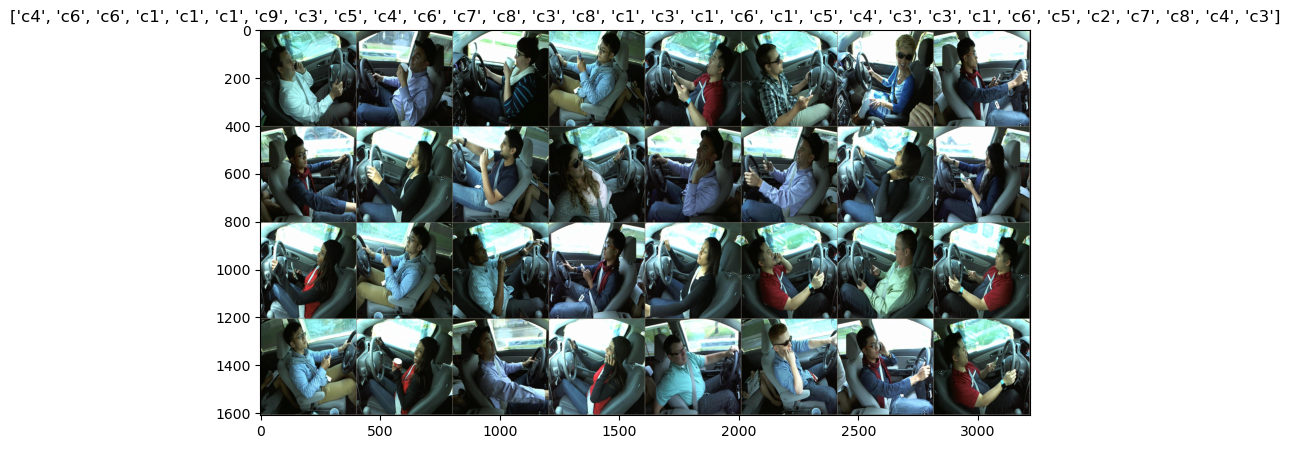

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

plt.figure(figsize = (15,5))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)



imshow(out, title=[class_labels[x] for x in classes])

#### Model Training

###### Defining the model

In [35]:
# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Freeze the parameters of the pre-trained layers
for param in model.parameters():
    param.requires_grad = False
    
    
num_classes = 10  
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

###### Training Loop

In [36]:

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=1, threshold = 0.9)


num_epochs = 10

train_losses = []
val_losses = []

train_accuracy_list = []
val_accuracy_list = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    train_accuracy = 100 * train_correct / train_total
    train_accuracy_list.append(train_accuracy)
    train_losses.append(train_loss / len(train_loader))
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_accuracy = 100 * val_correct / val_total
    val_accuracy_list.append(train_accuracy)
    val_losses.append(val_loss / len(val_loader))
    
    scheduler.step(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/10]
Train Loss: 24.7703, Train Accuracy: 36.90%
Val Loss: 28.6661, Val Accuracy: 40.11%
Epoch [2/10]
Train Loss: 21.4823, Train Accuracy: 49.12%
Val Loss: 19.0653, Val Accuracy: 57.68%
Epoch [3/10]
Train Loss: 21.6691, Train Accuracy: 53.02%
Val Loss: 16.1528, Val Accuracy: 63.59%
Epoch [4/10]
Train Loss: 11.0176, Train Accuracy: 65.94%
Val Loss: 7.7681, Val Accuracy: 74.88%
Epoch [5/10]
Train Loss: 7.8477, Train Accuracy: 71.17%
Val Loss: 6.5888, Val Accuracy: 75.99%
Epoch [6/10]
Train Loss: 6.4526, Train Accuracy: 72.79%
Val Loss: 5.7508, Val Accuracy: 77.46%
Epoch [7/10]
Train Loss: 6.3033, Train Accuracy: 73.17%
Val Loss: 5.6151, Val Accuracy: 77.59%
Epoch [8/10]
Train Loss: 6.0805, Train Accuracy: 73.60%
Val Loss: 5.8418, Val Accuracy: 77.28%
Epoch [9/10]
Train Loss: 5.8423, Train Accuracy: 73.69%
Val Loss: 5.1508, Val Accuracy: 79.27%
Epoch [10/10]
Train Loss: 5.9865, Train Accuracy: 73.55%
Val Loss: 5.4474, Val Accuracy: 78.02%


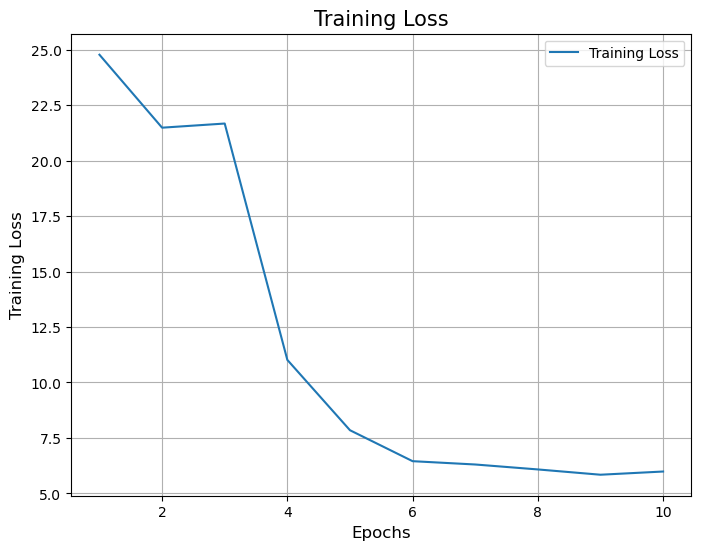

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
# plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs', size = 12)
plt.ylabel('Training Loss', size = 12)
plt.title('Training Loss', size = 15)
plt.legend()
plt.grid(True)
plt.show()

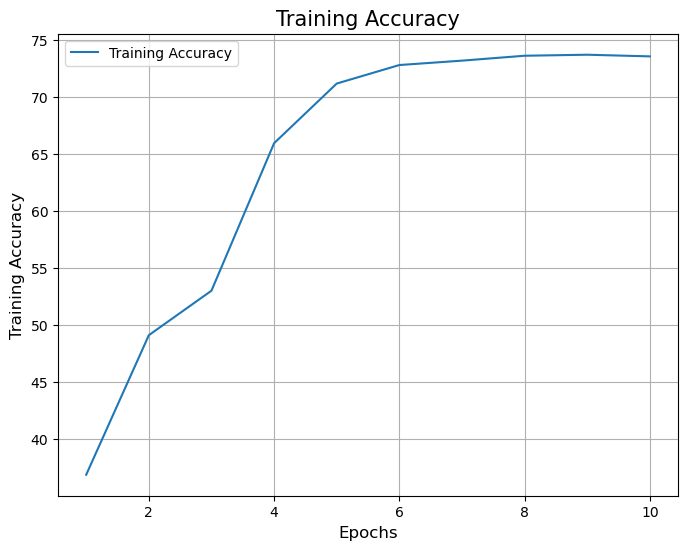

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Training Accuracy')
# plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs', size = 12)
plt.ylabel('Training Accuracy', size = 12)
plt.title('Training Accuracy', size = 15)
plt.legend()
plt.grid(True)
plt.show()

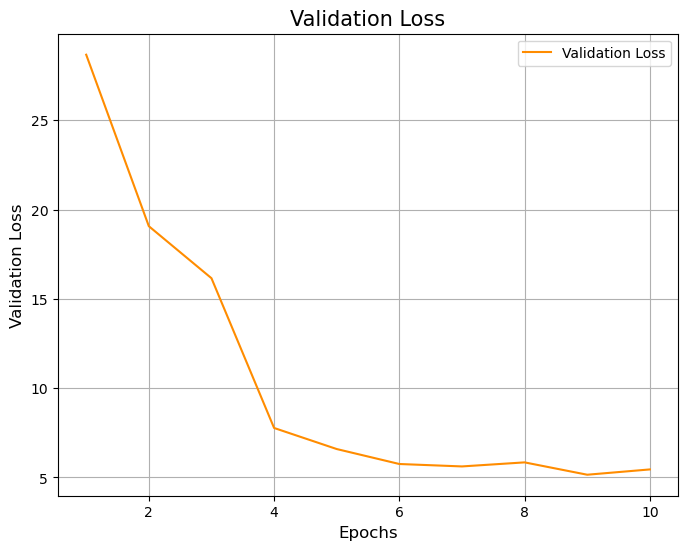

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), val_losses,  color = r"darkorange", label='Validation Loss')
plt.xlabel('Epochs', size = 12)
plt.ylabel('Validation Loss', size = 12)
plt.title('Validation Loss', size = 15)
plt.legend()
plt.grid(True)
plt.show()

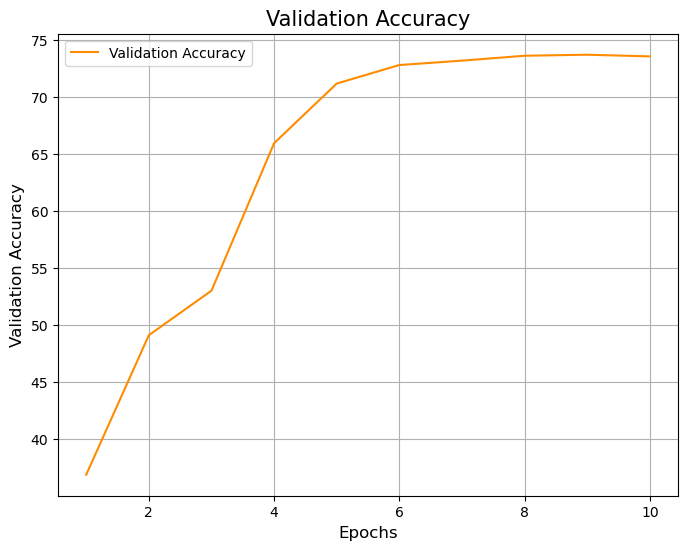

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), val_accuracy_list,  color = r"darkorange", label='Validation Accuracy')
plt.xlabel('Epochs', size = 12)
plt.ylabel('Validation Accuracy', size = 12)
plt.title('Validation Accuracy', size = 15)
plt.legend()
plt.grid(True)
plt.show()

#  Testing

##### Creating test dataset

In [42]:
# test_dir = r"/nfs/home/tgv3756/dlproject/data/imgs/test"
# class_labels = os.listdir(test_dir)

# # Creating folders for test images
# [os.makedirs(os.path.join(r"/nfs/home/tgv3756/dlproject/data", "resnet_test_data", class_label), exist_ok=True) for class_label in class_labels]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [47]:
# for label in tqdm(class_labels):
#     images = [i for i in os.listdir(os.path.join(test_dir, label)) if r'.jpg' in i]

#     for img in images:
#         shutil.copy(os.path.join(test_dir, label, img),
#                 os.path.join(r"/nfs/home/tgv3756/dlproject/data/resnet_test_data", label, img))

In [48]:
test_dir

'/nfs/home/tgv3756/dlproject/data/imgs/test'

In [68]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


test_dataset = UnlabeledImageDataset(image_dir=test_dir, transform = val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device as the model
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Store predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)

# Calculate loss
criterion = nn.CrossEntropyLoss()
test_loss = criterion(outputs, labels).item()

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

###### Display Test Cases

In [79]:
np.array(class_labels)[predicted[:5].tolist()]

array(['c6', 'c0', 'c2', 'c6', 'c4'], dtype='<U2')

In [15]:
val_loader

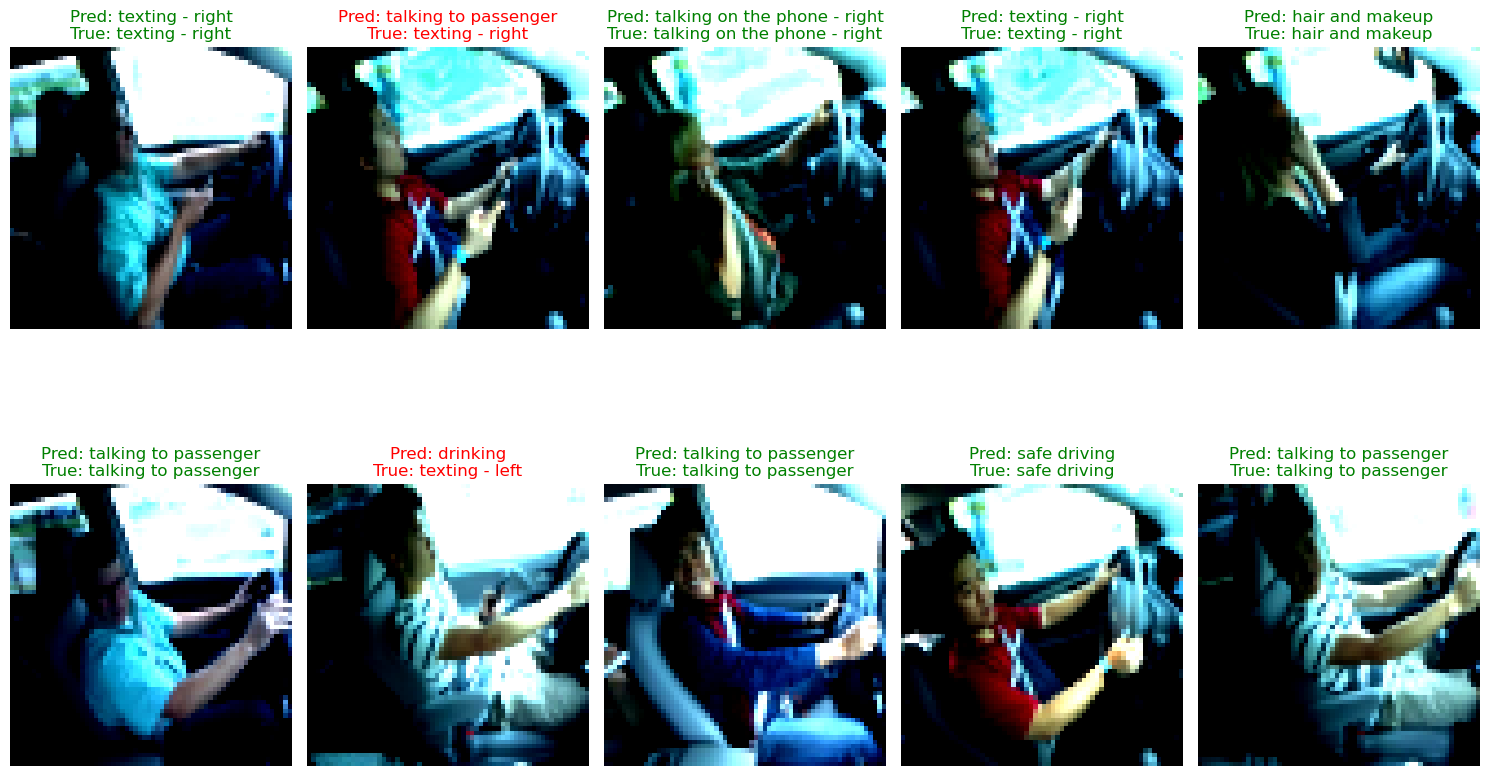

In [111]:
def imshow_test(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

num_images = 10
rows, cols = 2, 5

del test_loader
test_loader = DataLoader(val_dataset, batch_size=10, shuffle=True, generator=torch.Generator(device='cuda'))


model.eval()
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))  # Adjust figsize for better spacing

for idx in range(num_images):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col]  # Access the correct subplot in the grid

    img = images[idx].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img / 2 + 0.5     # Unnormalize
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    
    # Set title with prediction and true label
    color = "green" if predicted[idx] == labels[idx] else "red"
    ax.set_title(f"Pred: {label_mappings.get(class_labels[predicted[idx]])}\nTrue: {label_mappings.get(class_labels[labels[idx]])}", color=color)
    
    ax.axis("off")  # Turn off axis

plt.tight_layout()
plt.show()